### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 21 ноября 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold, train_test_split, cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [6]:
class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'class_error':
            self.G_function = self.__misclass
        else:
            print('name error')
            raise

    def __gini(self, p):
        return 1 - (p**2).sum(axis=1)

    def __entropy(self, p):
        return -np.sum(p[np.where(p > 0)] * np.log10(p[np.where(p > 0)]))

    def __misclass(self, p):
        return 1 - p.max(axis=1)


    def __get_feature_ids(self, n_feature):
        return range(n_feature)

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        x_sort, y_sort=self.__sort_samples(x,y)

        cut = int(self.min_samples_split / 2 - 1)
        y_sort_slit = y_sort[cut:-cut] if cut != 0 else y_sort
        indexes = np.where(y_sort_slit[:-1] != y_sort_slit[1:])[0] + (cut + 1)

        # Отсутствие смещения класса
        if len(indexes) == 0:
            return np.inf, None

        eq_count = indexes - np.append([cut], indexes[:-1])
        one_hot_code = np.zeros((indexes.shape[0], self.num_class))
        one_hot_code[np.arange(indexes.shape[0]), y_sort[indexes - 1]] = 1

        class_increments = one_hot_code * eq_count.reshape(-1, 1)
        class_increments[0] = class_increments[0] + np.bincount(y_sort[:cut], minlength=self.num_class)


        # количество классов слева и справа в разбиении
        l_class_count = np.cumsum(class_increments, axis=0)
        r_class_count = np.bincount(y_sort, minlength=self.num_class) - l_class_count

        # количество объектов слева и справа в разбиении
        l_sizes = indexes.reshape(l_class_count.shape[0], 1)
        r_sizes = y_sort.shape[0] - l_sizes

        gs_l = self.G_function(l_class_count/l_sizes)*(l_sizes/(l_sizes+r_sizes)).T
        gs_r = self.G_function(r_class_count/r_sizes)*(r_sizes/(l_sizes+r_sizes)).T
        gs = gs_l.T + gs_r.T

        indx = np.argmin(gs)

        st_ind = l_sizes[indx][0]

        return gs[indx], (x_sort[st_ind - 1] + x_sort[st_ind]) / 2.0


    def __fit_node(self, x, y, node_id, depth):
        # создаем терминал.
        if (self.max_depth<=depth) or y.size < self.min_samples_split:
            self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y).astype(float) / y.size)
            return

        # разбиваем
        threshold = np.array([self.__find_threshold(x[:, i], y) for i in self.__get_feature_ids(x.shape[1])], dtype=object)

        # оптимальная группа
        best_id = threshold[:, 0].argmin()
        best_threshold = threshold[best_id, 1]

        # если узел создался и нашлась группа, то спускаемся по дереву дальше, если нет, то создаем терминал.
        if best_threshold == None:
            self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y).astype(float) / y.size)
        else:
            x_l, x_r, y_l, y_r =self.__div_samples(x, y, best_id, best_threshold)
            if x_l.size == 0 or x_r.size == 0:
                self.tree[node_id] = (self.LEAF_TYPE,np.bincount(y).argmax(),np.bincount(y).astype(float) / y.size)
            else:
                self.tree[node_id] = (self.NON_LEAF_TYPE,best_id, best_threshold)
                self.__fit_node(x_l, y_l,2 * node_id + 1, depth + 1)
                self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
            # для последнего этапа. Очевидно, лучше считать здесь. Просто считаем gain лучших фичей и плюсуем
            # в feature_importances_ по индексу
            # все делаем через numpy для ускорения
            if self.G_function == self.__gini:
                g=(1 - np.sum(np.unique(y, return_counts=True)[1]** 2 / y.size ** 2))
                g_l=(1 - np.sum(np.unique(y_l, return_counts=True)[1] ** 2 / y_l.size ** 2))
                g_r=(1 - np.sum(np.unique(y_r, return_counts=True)[1] ** 2 / y_r.size ** 2))
                self.feature_importances_[best_id] += (y.size*g - y_l.size*g_l - y_r.size*g_r)/y.size
            if self.G_function == self.__entropy:
                g=-(np.sum((np.unique(y, return_counts=True)[1] / y.size) * np.log2(np.unique(y, return_counts=True)[1] / y.size)))
                g_l=-(np.sum((np.unique(y_l, return_counts=True)[1] / y_l.size) * np.log2(np.unique(y_l, return_counts=True)[1] / y_l.size)))
                g_r=-(np.sum((np.unique(y_r, return_counts=True)[1] / y_r.size) * np.log2(np.unique(y_r, return_counts=True)[1] / y_r.size)))
                self.feature_importances_[best_id] += (y.size*g - y_l.size*g_l - y_r.size*g_r)/y.size
            elif self.G_function == self.__misclass:
                g=(1 - np.max(np.sum(np.unique(y, return_counts=True)[1] / y.size)))
                g_l=(1 - np.max(np.sum(np.unique(y_l, return_counts=True)[1] / y.size)))
                g_r=(1 - np.max(np.sum(np.unique(y_r, return_counts=True)[1] / y.size)))
                self.feature_importances_[best_id] += (y.size*g - y_l.size*g_l - y_r.size*g_r)/y.size


    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1], dtype=float)
        self.total = y.size
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        # индексы десяти главных фичей
        return (self.feature_importances_)

In [11]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [12]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [13]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [14]:
print(f'clf: {accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)}')
print(f'my_clf: {accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)}')

clf: 0.8888888888888888
my_clf: 0.9444444444444444


Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы.
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [15]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {0: (1, 0, array([0.5, 0.5]))} [0 0 0 0 0 0 0 0 0 0]
DEPTH: 2 
		Tree: {0: (1, 0, array([0.5, 0.5]))} [0 0 0 0 0 0 0 0 0 0]
DEPTH: 3 
		Tree: {0: (1, 0, array([0.5, 0.5]))} [0 0 0 0 0 0 0 0 0 0]
DEPTH: 4 
		Tree: {0: (1, 0, array([0.5, 0.5]))} [0 0 0 0 0 0 0 0 0 0]


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine.
Для этого используем numpy.

In [18]:
%time clf.fit(X_train, y_train)

CPU times: user 2.2 ms, sys: 0 ns, total: 2.2 ms
Wall time: 2.23 ms


DecisionTreeClassifier()

In [19]:
%time my_clf.fit(X_train, y_train)

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 15.5 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match).

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [91]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]

    to_drop = [
        'id', 'pid', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner',
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise',
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies',
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100

    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)

    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
                'intel{}_1'.format(i), 'fun{}_1'.format(i),
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))

        df = df.drop(feat, axis=1)

    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc.


In [92]:
df = pd.read_csv('/content/Speed_Dating_Data.csv', encoding='latin1')

In [93]:
df = preprocess_spd_data(df)

In [94]:
df_X,df_y = df.drop(['match'], axis=1, inplace=False), df.match
X,y = df_X.to_numpy(), df_y.to_numpy()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

my_clf = MyDecisionTreeClassifier(min_samples_split=5, max_depth=5, criterion='gini')
clf = DecisionTreeClassifier(min_samples_split=5, max_depth=5, criterion='gini') #чтобы установить равные условия

clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [84]:
y_pred_clf = clf.predict(X_test)
y_pred_my_clf = my_clf.predict(X_test)

accuracy_clf = accuracy_score(y_pred=y_pred_clf, y_true=y_test)
accuracy_my_clf = accuracy_score(y_pred=y_pred_my_clf, y_true=y_test)

roc_auc_clf = roc_auc_score(y_true=y_test, y_score=y_pred_clf)
roc_auc_my_clf = roc_auc_score(y_true=y_test, y_score=y_pred_my_clf)

print(f'clf - Accuracy: {accuracy_clf}, ROC-AUC: {roc_auc_clf}')
print(f'my_clf - Accuracy: {accuracy_my_clf}, ROC-AUC: {roc_auc_my_clf}')

clf - Accuracy: 0.8286066584463625, ROC-AUC: 0.501619091977732
my_clf - Accuracy: 0.8323057953144266, ROC-AUC: 0.5068534167276598


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности.
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [63]:
samples=range(1, 55, 3)
criterions=['gini','entropy','class_error']
depths=range(1, 25, 2)

In [71]:
# будем смотреть на f1 меру, чтобы оптимизировать и recall и precision
max_criterions=[]
for criterion in tqdm(criterions):
    my_clf = MyDecisionTreeClassifier(criterion=criterion)
    my_clf.fit(X_train, y_train)
    valid=cross_val_score(my_clf, X_train, y_train, cv=5, scoring="f1").mean()
    max_criterions.append(valid)

  0%|          | 0/3 [00:00<?, ?it/s]

In [72]:
max_criterions

[0.02074729122618138, 0.0033195592286501376, 0.011316548649357461]

In [73]:
max_criterion=criterions[np.argmax(max_criterions)]
print(f'Max criterion: {max_criterion}')

Max criterion: gini


Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн.
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации?

In [ ]:
from joblib import Parallel, delayed

max_score = 0
max_sample = 0
max_depth = 0

def evaluate(sample, depth, X_train, y_train):
    my_clf = MyDecisionTreeClassifier(min_samples_split=sample, max_depth=depth, criterion=max_criterion)
    my_clf.fit(X_train, y_train)
    valid = cross_val_score(my_clf, X_train, y_train, cv=5, scoring="f1").mean()
    return valid, sample, depth



results = Parallel(n_jobs=-1)(delayed(evaluate)(sample, depth, X_train, y_train) for sample in tqdm(samples) for depth in depths)


for valid, sample, depth in results:
    if valid > max_score:
        max_score = valid
        max_sample = sample
        max_depth = depth

print(f"Max Score: {max_score}, Max Sample: {max_sample}, Max Depth: {max_depth}")


  0%|          | 0/18 [00:00<?, ?it/s]

Max Score: 0.10709583034533644, Max Sample: 16, Max Depth: 13


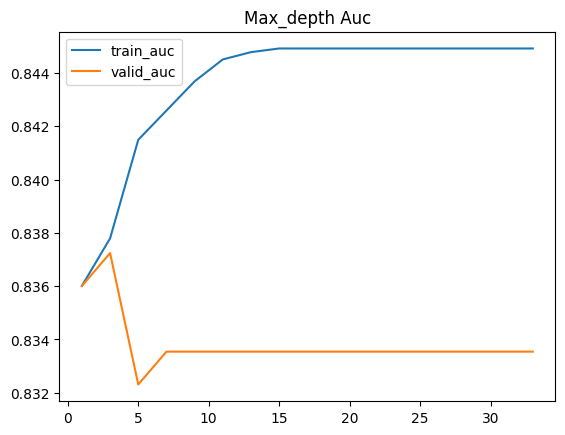

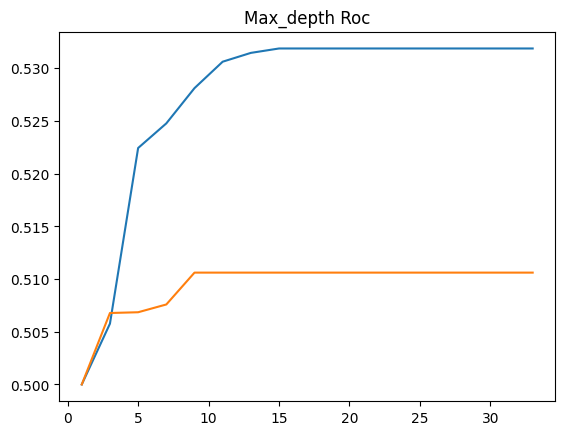

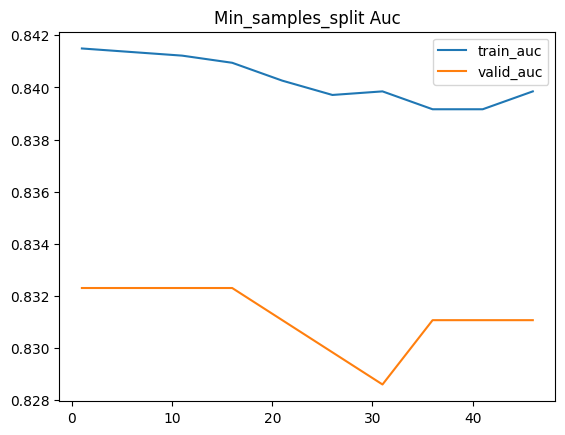

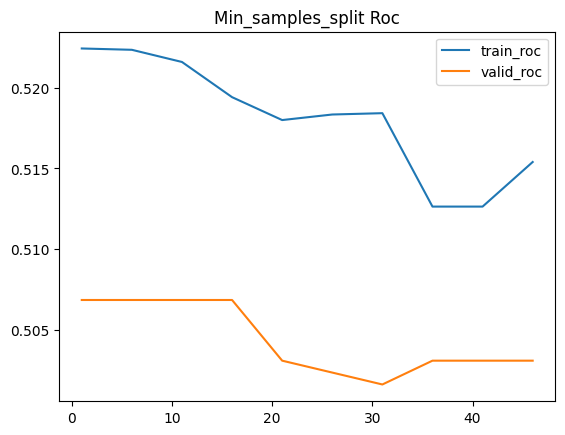

In [80]:
score_train_auc=[]
score_valid_auc=[]
score_train_roc=[]
score_valid_roc=[]
params=range(1, 35, 2)
for n in params:
    model = MyDecisionTreeClassifier(min_samples_split=2, max_depth=n, criterion='gini')
    model.fit(X_train, y_train)
    score_train_auc.append(accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    score_valid_auc.append(accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    score_train_roc.append(roc_auc_score(y_true=y_train, y_score=model.predict(X_train)))
    score_valid_roc.append(roc_auc_score(y_true=y_test, y_score=model.predict(X_test)))
plt.plot(params, score_train_auc, label='train_auc')
plt.plot(params, score_valid_auc, label='valid_auc')
plt.legend()
plt.title('Max_depth Auc')
plt.show()
plt.plot(params, score_train_roc, label='train_roc')
plt.plot(params, score_valid_roc, label='valid_roc')
plt.title('Max_depth Roc')
plt.show()

score_train_auc=[]
score_valid_auc=[]
score_train_roc=[]
score_valid_roc=[]
params=range(1, 50, 5)
for n in params:
    model = MyDecisionTreeClassifier(min_samples_split=n, max_depth=5, criterion='gini')
    model.fit(X_train, y_train)
    score_train_auc.append(accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    score_valid_auc.append(accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    score_train_roc.append(roc_auc_score(y_true=y_train, y_score=model.predict(X_train)))
    score_valid_roc.append(roc_auc_score(y_true=y_test, y_score=model.predict(X_test)))
plt.plot(params, score_train_auc, label='train_auc')
plt.plot(params, score_valid_auc, label='valid_auc')
plt.legend()
plt.title('Min_samples_split Auc')
plt.show()
plt.plot(params, score_train_roc, label='train_roc')
plt.plot(params, score_valid_roc, label='valid_roc')
plt.legend()
plt.title('Min_samples_split Roc')
plt.show()

In [85]:
my_clf = MyDecisionTreeClassifier(min_samples_split=10, max_depth=7, criterion='gini')
my_clf.fit(X_train, y_train)
print(roc_auc_score(y_true=y_train, y_score=model.predict(X_train)))

print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.5154022648344517
0.8310727496917386


Как видно по графикам дерево действительно переобучается с увеличением глубины и при этом качество при обучении растет а на валидации падает.

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве.

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший.
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева.

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [95]:
my_clf = MyDecisionTreeClassifier(min_samples_split=5, max_depth=5, criterion='gini')
my_clf.fit(X_train, y_train)

feature_importance = list(zip(df_X.columns, my_clf.get_feature_importance()))

feature_importance.sort(key=lambda x: x[1], reverse=True)

for feature, importance in feature_importance[:10]:
    print(f"{feature}: {importance}")

field_cd: 0.2484908638292614
int_corr: 0.2117171406342603
intel2_1: 0.08081678940956656
shar1_1: 0.07138677779862804
attr1_1: 0.0679730672126522
imprelig: 0.04542048304301262
shar2_1: 0.007342077787624671
race: 0.004281778827233298
attr2_1: 0.0032610892416312445
go_out: 0.0011960915107984281


Результаты интересные и в целом похожие на правду.

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

*  Еще немного подробнее хотел бы услышать про максимизацию функционала, а также обработку данных для деревьев. А так в целом много времени потратил на оптимизацию с помощью np. но в целом это вроде нужно, хотя и есть готовые методы. Ну и обучается для оценки параметров, очень долго, поэтому не смог оценить параметры и провести исследование в той мере, в которой хотел.

### ВАШ ОТЗЫВ ЗДЕСЬ

